## 1. Import libraries and load raw data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

train = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

train.head(), test.head()


(         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
 0  02.01.2013               0       59    22154      999.00           1.0
 1  03.01.2013               0       25     2552      899.00           1.0
 2  05.01.2013               0       25     2552      899.00          -1.0
 3  06.01.2013               0       25     2554     1709.05           1.0
 4  15.01.2013               0       25     2555     1099.00           1.0,
    ID  shop_id  item_id
 0   0        5     5037
 1   1        5     5320
 2   2        5     5233
 3   3        5     5232
 4   4        5     5268)

## 2. Aggregate daily sales to monthly item_cnt_month

In [2]:
monthly = (
    train
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"]
    .sum()
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)

print("Monthly shape:", monthly.shape)
monthly.head()


Monthly shape: (1609124, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


## 3. Create lag-1 feature and build modeling dataset

In [3]:
monthly_sorted = monthly.sort_values(["shop_id", "item_id", "date_block_num"])

monthly_sorted["item_cnt_month_lag1"] = (
    monthly_sorted
    .groupby(["shop_id", "item_id"])["item_cnt_month"]
    .shift(1)
)

data = monthly_sorted.dropna(subset=["item_cnt_month_lag1"]).copy()
print("Modeling data shape (non-missing lag):", data.shape)
data.head()


Modeling data shape (non-missing lag): (1185000, 5)


,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag1
63226,1,0,32,10.0,6.0
63227,1,0,33,3.0,3.0
63228,1,0,35,14.0,1.0
63233,1,0,51,3.0,2.0
63238,1,0,98,5.0,25.0


## 4. Train/validation split and prepare features

In [4]:
train_data = data[data["date_block_num"] < 33]
val_data   = data[data["date_block_num"] == 33]

print("Train rows:", train_data.shape[0])
print("Validation rows:", val_data.shape[0])

X_train = train_data[["item_cnt_month_lag1"]]
y_train = train_data["item_cnt_month"]

X_val = val_data[["item_cnt_month_lag1"]]
y_val = val_data["item_cnt_month"]


Train rows: 1160589
Validation rows: 24411


## 5. Train linear regression and evaluate with RMSE

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

val_pred = model.predict(X_val)

rmse_val = mean_squared_error(y_val, val_pred, squared=False)
rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)

print("Training RMSE:", rmse_train)
print("Validation RMSE (month 33):", rmse_val)


Training RMSE: 6.052667207299196
Validation RMSE (month 33): 14.13302633756186


## 6. Plot distribution of monthly item_cnt_month

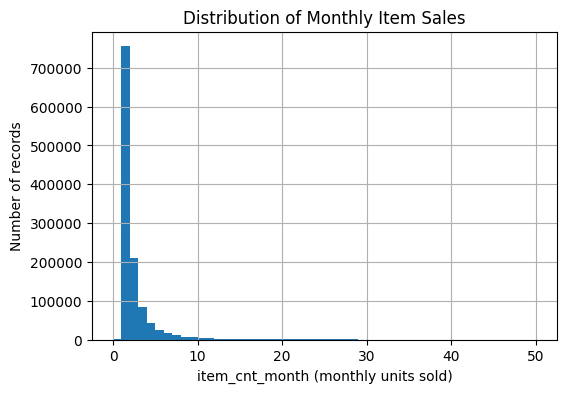

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(data["item_cnt_month"], bins=50, range=(0, 50))
plt.xlabel("item_cnt_month (monthly units sold)")
plt.ylabel("Number of records")
plt.title("Distribution of Monthly Item Sales")
plt.grid(True)
plt.show()


## 7. Scatter plot of predicted vs actual (sampled validation points)

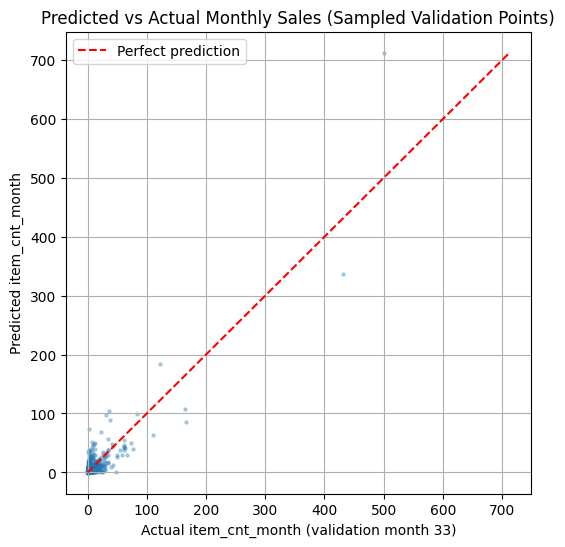

In [7]:
# Convert to arrays
y_val_array = y_val.values
val_pred_array = val_pred

# Sample up to 10,000 points
sample_size = 10000
n = len(y_val_array)
idx = np.random.choice(n, size=min(sample_size, n), replace=False)

y_sample = y_val_array[idx]
pred_sample = val_pred_array[idx]

plt.figure(figsize=(6, 6))
plt.scatter(y_sample, pred_sample, alpha=0.3, s=5)

max_val = max(y_sample.max(), pred_sample.max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", label="Perfect prediction")

plt.xlabel("Actual item_cnt_month (validation month 33)")
plt.ylabel("Predicted item_cnt_month")
plt.title("Predicted vs Actual Monthly Sales (Sampled Validation Points)")
plt.legend()
plt.grid(True)
plt.show()


## 8. Prepare test data with lag-1 feature

In [8]:
# Get October 2015 (month 33) monthly sales
oct_2015 = monthly[monthly["date_block_num"] == 33][["shop_id", "item_id", "item_cnt_month"]]

oct_2015 = oct_2015.rename(columns={"item_cnt_month": "item_cnt_month_lag1"})

test_with_lag = test.merge(oct_2015, on=["shop_id", "item_id"], how="left")
test_with_lag["item_cnt_month_lag1"] = test_with_lag["item_cnt_month_lag1"].fillna(0)

print("Test with lag shape:", test_with_lag.shape)
test_with_lag.head()


Test with lag shape: (214200, 4)


,ID,shop_id,item_id,item_cnt_month_lag1
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0


## 9. Refit model on full data and create Kaggle submission

In [9]:
X_full = data[["item_cnt_month_lag1"]]
y_full = data["item_cnt_month"]

final_model = LinearRegression()
final_model.fit(X_full, y_full)

X_test_final = test_with_lag[["item_cnt_month_lag1"]]
test_pred = final_model.predict(X_test_final)

# Optional clipping like many kernels do
test_pred_clipped = np.clip(test_pred, 0, 20)

submission = pd.DataFrame({
    "ID": test_with_lag["ID"],
    "item_cnt_month": test_pred_clipped
})

submission.to_csv("submission.csv", index=False)
submission.head()


,ID,item_cnt_month
0,0,0.407494
1,1,0.407494
2,2,1.120122
3,3,0.407494
4,4,0.407494
